In [1]:
import torch
from lightglue import LightGlue, SuperPoint, DISK, SIFT
from lightglue.utils import load_image, rbd, numpy_image_to_torch
from lightglue import viz2d
from pathlib import Path
import os
import cv2
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
   

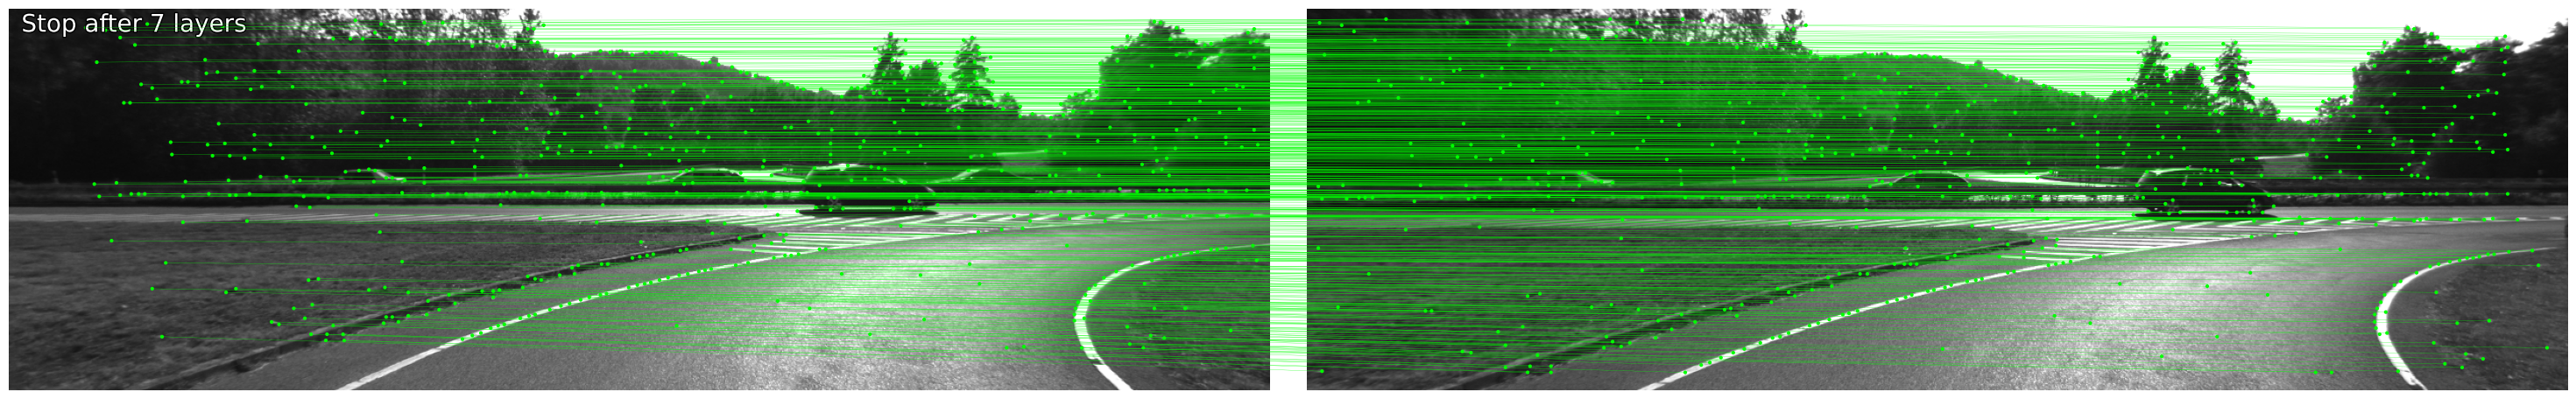

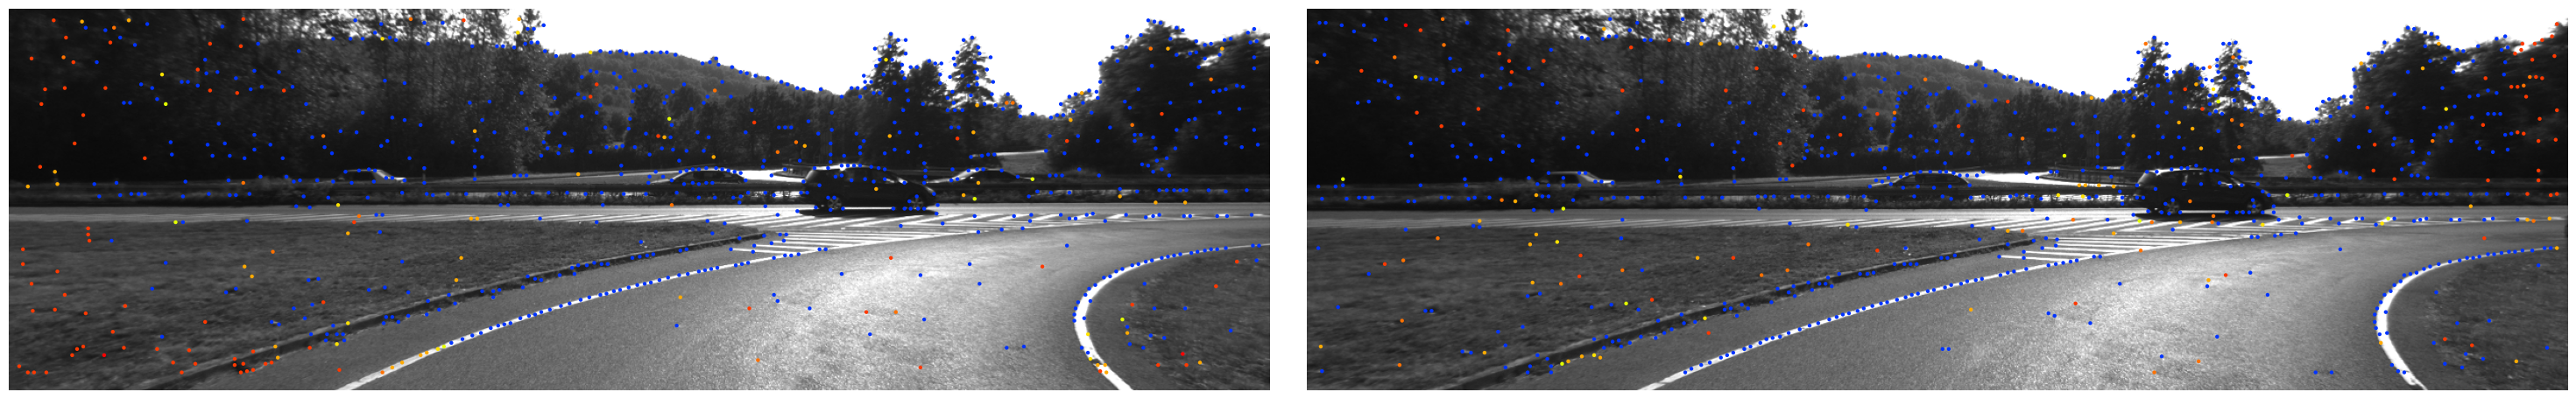

In [2]:
images = Path("../Lane_detection/kitti01_image0/")  #assets
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

extractor = SuperPoint(max_num_keypoints=2048).eval().to(device)
matcher = LightGlue(features="superpoint").eval().to(device)

image0 = load_image(images / "000002.png")  #DSC_0411.JPG
image1 = load_image(images / "000003.png")  #DSC_0410.JPG

feats0 = extractor.extract(image0.to(device))
feats1 = extractor.extract(image1.to(device))
matches01 = matcher({"image0": feats0, "image1": feats1})

feats0, feats1, matches01 = [rbd(x) for x in [feats0, feats1, matches01]] #remove batch dimension

kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)
viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)

kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
viz2d.plot_images([image0, image1])
viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=10)

In [3]:
print(f"Feature detected in image 0: {kpts0.size()[0]}")
print(f"Feature detected in image 1: {kpts1.size()[0]}")
print(f"Keypoints matched in image 0: {m_kpts0.size()[0]}")
print(f"Keypoints matched in image 1: {m_kpts1.size()[0]}")

Feature detected in image 0: 871
Feature detected in image 1: 914
Keypoints matched in image 0: 618
Keypoints matched in image 1: 618


P0(c,r): (340.65380859375,11.022581100463867)
P1(c,r): (298.23681640625,9.809677124023438)


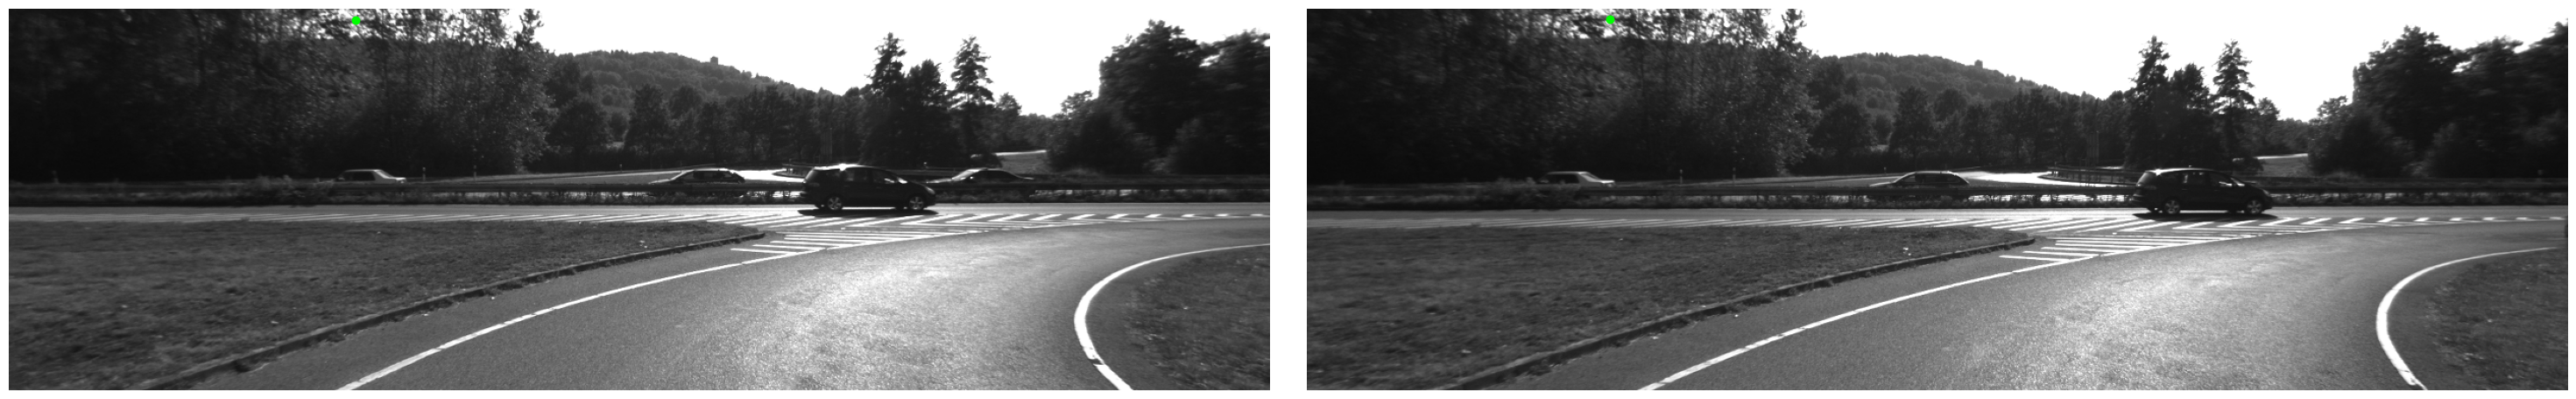

In [4]:
viz2d.plot_images([image0, image1])
viz2d.plot_keypoints([m_kpts0[:1,:], m_kpts1[:1,:]], colors="lime", ps=50)
print(f"P0(c,r): ({m_kpts0[0,0]},{m_kpts0[0,1]})")
print(f"P1(c,r): ({m_kpts1[0,0]},{m_kpts1[0,1]})")

**RUNNING ON A SEQUENCE**

In [5]:
calibPath = 'calib.txt'
posesPath = 'poses.txt'

#load intrinsic parameters
with open(calibPath, 'r') as f:
    params = np.fromstring(f.readline(), dtype=np.float64, sep=' ')
    P = np.reshape(params, (3,4))
    K = P[0:3, 0:3]
print(f"\nIntrinsic matrix K:\n {K}")

#load ground truth poses
poses = []
with open(posesPath, 'r') as f:
    for line in f.readlines():
        T = np.fromstring(line, dtype=np.float64, sep= ' ')
        T = T.reshape(3, 4)
        T = np.vstack((T, [0, 0, 0, 1]))
        poses.append(T)


Intrinsic matrix K:
 [[718.856    0.     607.1928]
 [  0.     718.856  185.2157]
 [  0.       0.       1.    ]]


In [6]:
images = Path("../Lane_detection/kitti01_image0/")  #assets

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

extractor = SuperPoint(max_num_keypoints=2048).eval().to(device)
matcher = LightGlue(features="superpoint").eval().to(device)



imgs = [x for x in os.listdir(images)]
imgs.sort()
print(len(imgs))

1101


In [7]:

def form_transf(R, t):
    """
    Makes a transformmation matrix from given rotation matrix and translation vector

    Parameters
    ----------
    R (ndarray): Rotation matrix
    t (list): Translation vector

    Retruns
    -------
    T (ndarray): Transformation matrix
    """
    T = np.eye(4, dtype=np.float64)
    T[:3, :3] = R
    T[:3, 3] = t
    return T

def sum_z_cal_relative_scale(R, t, q1, q2):
    # get the transformation matrix
    T = form_transf(R, t)
    # make the projection matrix
    PM = np.matmul(np.concatenate((K, np.zeros((3,1))), axis=1), T)

    # triangulate the 3D point
    hom_Q1 = cv2.triangulatePoints(P, PM, q1.T, q2.T)
    # also seen from cam 2
    hom_Q2 = np.matmul(T, hom_Q1)

    # un-homogenize
    uhom_Q1 = hom_Q1[:3, :] / hom_Q1[3, :]
    uhom_Q2 = hom_Q2[:3, :] / hom_Q2[3, :]

    # find the number of points having positive z coordinate in both cameras
    sum_of_pos_z_Q1 = sum(uhom_Q1[2, :] > 0)
    sum_of_pos_z_Q2 = sum(uhom_Q2[2, :] > 0)

    # form point pairs and calculate the relative scale
    relative_scale = np.mean(np.linalg.norm(uhom_Q1.T[:-1] - uhom_Q1.T[1:], axis=-1)/
                             np.linalg.norm(uhom_Q2.T[:-1] - uhom_Q2.T[1:], axis=-1))
    return sum_of_pos_z_Q1 + sum_of_pos_z_Q2, relative_scale
    
    



#---------- VISUAL ODOMETRY ----------#
gt_path = []
estimated_path = []

for i in range(10):
    print(f"Frame {i+1}/{len(imgs)}")
    gt_pose = poses[i]
    if i == 0:
        cur_pose = gt_pose
    else:
        im0 = load_image(images / imgs[i-1])
        im1 = load_image(images / imgs[i])
        feats0 = extractor.extract(im0.to(device))
        feats1 = extractor.extract(im1.to(device))
        matches01 = matcher({"image0": feats0, "image1": feats1})

        feats0, feats1, matches01 = [rbd(x) for x in [feats0, feats1, matches01]] #remove batch dimension

        kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
        m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

        scores = matches01["scores"].detach().numpy()
                    
        q1 = np.float32(m_kpts0)    #list of keypoints in image 1
        q2 = np.float32(m_kpts1)    #list fo keypoints in image 2
        
        print(f"q1 and q2 before optim: {len(q1)}, {len(q1)}")
        
        delete = []
        for j in range(len(scores)):
            if scores[j] < 0.6:
                delete.append(j)
        #print(f"Detele: {delete}")
        q1 = np.delete(q1, delete, axis=0)
        q2 = np.delete(q2, delete, axis=0)
        scores = np.delete(scores, delete, axis=0)
        print(f"q1 and q2 after optim: {len(q1)}, {len(q2)}")
        
        E, _ = cv2.findEssentialMat(q1, q2, K, threshold=1) #compute E from keypoints
    
        #decompose the Eseential matrix by SVD
        R1, R2, t = cv2.decomposeEssentialMat(E)
        t = np.squeeze(t)
    
        # make a list of the different possible pairs 
        pairs = [[R1, t], [R1, -t], [R2, t], [R2, -t]]
        # check which solution is the right one
        z_sums = []
        relative_scales = []
        for R,t in pairs:
            z_sum, scale = sum_z_cal_relative_scale(R,t, q1, q2)
            z_sums.append(z_sum)
            relative_scales.append(scale)

        # select the pair with the highest number of points with positive z coordinate
        right_pair_idx = np.argmax(z_sum)
        right_pair = pairs[right_pair_idx]
        relative_scale = relative_scales[right_pair_idx]
        R1, t = right_pair
        t = t * relative_scale

        # compute the transformation matrix [R t]
        transformation_matrix = form_transf(R1, np.squeeze(t))

        #print(f"\nR:\n {R1}\n")
        #print(f"t:\n {t}\n")
        #print(f"[R t]:\n {transformation_matrix}")
        
        cur_pose = np.matmul(cur_pose, np.linalg.inv(transformation_matrix))
        
    gt_path.append((gt_pose[0,3], gt_pose[2,3]))
    estimated_path.append((cur_pose[0,3], cur_pose[2,3]))



    

Frame 1/1101
Frame 2/1101
q1 and q2 before optim: 609, 609
q1 and q2 after optim: 517, 517
Frame 3/1101
q1 and q2 before optim: 594, 594
q1 and q2 after optim: 519, 519
Frame 4/1101
q1 and q2 before optim: 618, 618
q1 and q2 after optim: 526, 526
Frame 5/1101
q1 and q2 before optim: 633, 633
q1 and q2 after optim: 543, 543
Frame 6/1101
q1 and q2 before optim: 649, 649
q1 and q2 after optim: 557, 557
Frame 7/1101
q1 and q2 before optim: 615, 615
q1 and q2 after optim: 531, 531
Frame 8/1101
q1 and q2 before optim: 610, 610
q1 and q2 after optim: 526, 526
Frame 9/1101
q1 and q2 before optim: 671, 671
q1 and q2 after optim: 574, 574
Frame 10/1101
q1 and q2 before optim: 686, 686
q1 and q2 after optim: 608, 608


In [8]:
print(len(gt_path))
print(len(estimated_path))

for j in range(len(gt_path)):
    
    print(f"\n---- FRAME {j+1} ----\n")
    print(f"Ground truth pose: {gt_path[j]}")
    print(f"Estimated pose: {estimated_path[j]}")

10
10

---- FRAME 1 ----

Ground truth pose: (1.110223e-16, -2.220446e-16)
Estimated pose: (1.110223e-16, -2.220446e-16)

---- FRAME 2 ----

Ground truth pose: (0.05154656, 1.000725)
Estimated pose: (-0.05294623890835068, -0.998344006014691)

---- FRAME 3 ----

Ground truth pose: (0.1464632, 1.995659)
Estimated pose: (-0.07025037035674633, -1.9981335555703423)

---- FRAME 4 ----

Ground truth pose: (0.2879204, 2.986691)
Estimated pose: (-0.05760036174114849, -2.9979612526539494)

---- FRAME 5 ----

Ground truth pose: (0.4657503, 3.963845)
Estimated pose: (-0.10748249039583019, -3.9962213505563855)

---- FRAME 6 ----

Ground truth pose: (0.6971645, 4.934639)
Estimated pose: (-0.25217605034383545, -4.985558849446307)

---- FRAME 7 ----

Ground truth pose: (0.9715689, 5.887651)
Estimated pose: (-0.4111216023527196, -5.972716950971594)

---- FRAME 8 ----

Ground truth pose: (1.288079, 6.826202)
Estimated pose: (-0.19971274337875264, -4.995331810631145)

---- FRAME 9 ----

Ground truth pose

In [3]:

from sklearn.metrics import confusion_matrix

from bokeh.models import TabPanel, Tabs
from bokeh.io import output_file, show
from bokeh.plotting import figure, ColumnDataSource
from bokeh.layouts import column, layout, gridplot
from bokeh.models import Div, WheelZoomTool


def visualize_paths(gt_path, pred_path, html_tile="", title="VO exercises", file_out="plot.html"):
    output_file(file_out, title=html_tile)
    gt_path = np.array(gt_path)
    pred_path = np.array(pred_path)

    tools = "pan,wheel_zoom,box_zoom,box_select,lasso_select,reset"

    gt_x, gt_y = gt_path.T
    pred_x, pred_y = pred_path.T
    xs = list(np.array([gt_x, pred_x]).T)
    ys = list(np.array([gt_y, pred_y]).T)

    diff = np.linalg.norm(gt_path - pred_path, axis=1)
    source = ColumnDataSource(data=dict(gtx=gt_path[:, 0], gty=gt_path[:, 1],
                                        px=pred_path[:, 0], py=pred_path[:, 1],
                                        diffx=np.arange(len(diff)), diffy=diff,
                                        disx=xs, disy=ys))

    fig1 = figure(title="Paths", tools=tools, match_aspect=True, width_policy="max", toolbar_location="above",
                  x_axis_label="x", y_axis_label="y")
    fig1.circle("gtx", "gty", source=source, color="blue", hover_fill_color="firebrick", legend_label="GT")
    fig1.line("gtx", "gty", source=source, color="blue", legend_label="GT")

    fig1.circle("px", "py", source=source, color="green", hover_fill_color="firebrick", legend_label="Pred")
    fig1.line("px", "py", source=source, color="green", legend_label="Pred")

    fig1.multi_line("disx", "disy", source=source, legend_label="Error", color="red", line_dash="dashed")
    fig1.legend.click_policy = "hide"

    fig2 = figure(title="Error", tools=tools, width_policy="max", toolbar_location="above",
                  x_axis_label="frame", y_axis_label="error")
    fig2.circle("diffx", "diffy", source=source, hover_fill_color="firebrick", legend_label="Error")
    fig2.line("diffx", "diffy", source=source, legend_label="Error")

    show(layout([Div(text=f"<h1>{title}</h1>"),
                 Div(text="<h2>Paths</h1>"),
                 [fig1, fig2],
                 ], sizing_mode='scale_width'))
    
    


#visualize_paths(gt_path, estimated_path, "Visual Odometry", file_out=os.path.basename(".") + ".html")

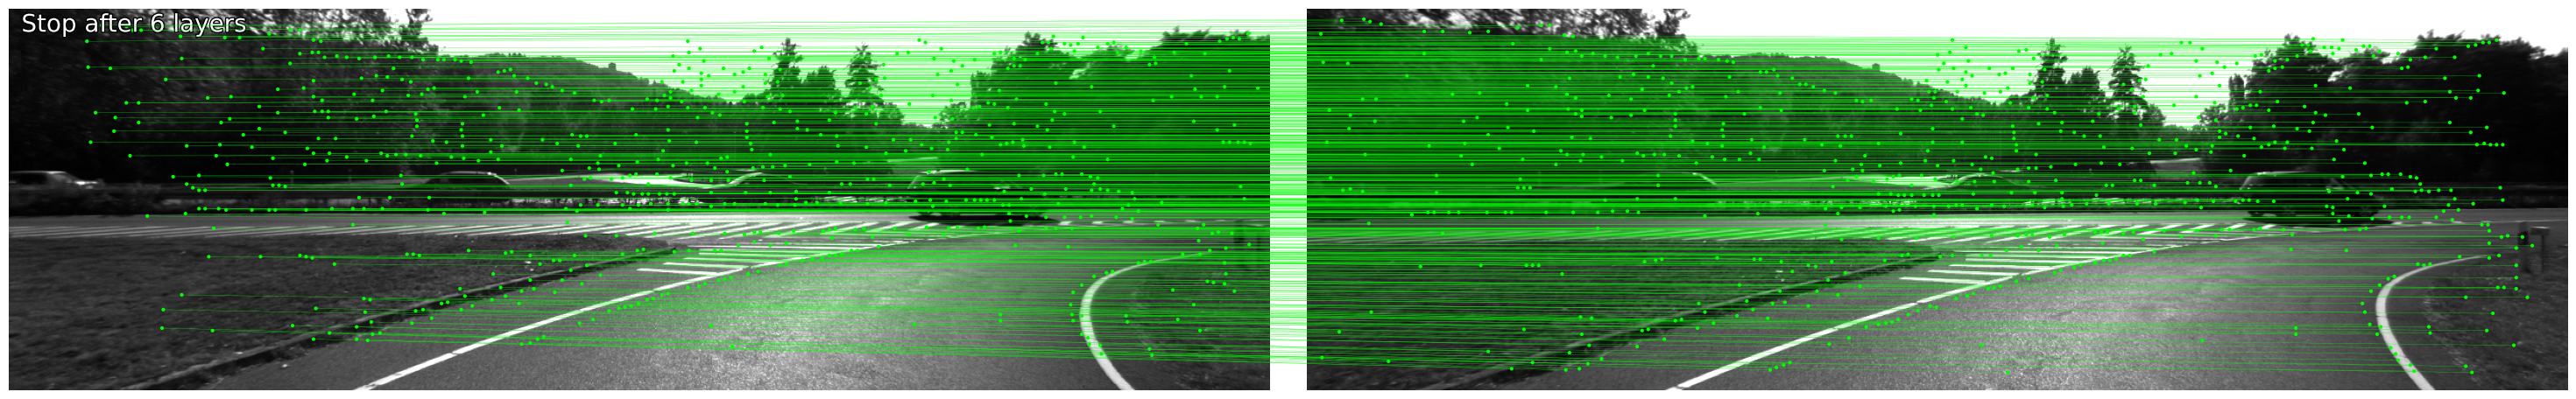

In [9]:
#View results
for j in range(6):
    clear_output(wait=True)
    im0 = cv2.imread(os.path.join(images, imgs[j]), cv2.IMREAD_GRAYSCALE)      #load_image(images / imgs[j])
    im1 = cv2.imread(os.path.join(images, imgs[j+1]), cv2.IMREAD_GRAYSCALE)      #load_image(images / imgs[j+1])
    
    axes = viz2d.plot_images([im0, im1])
    viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)
    viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)
    plt.pause(0.1)

504
504
504
[[ 145.53564    14.66129 ]
 [ 423.06396    14.66129 ]
 [ 454.57373    14.66129 ]
 [1196.2651     14.66129 ]
 [ 272.78662    15.874193]
 [1230.1987     15.874193]
 [  89.7876     17.087097]
 [ 297.0249     17.087097]
 [ 444.87842    18.300001]
 [ 338.22998    20.725807]]
Keypoint 1: [145.53564  14.66129], [87.36377   9.809677], score: 0.9488363862037659
Keypoint 2: [423.06396  14.66129], [383.0708    11.022581], score: 0.9977726936340332
Keypoint 3: [454.57373  14.66129], [415.79248   11.022581], score: 0.964688777923584
Keypoint 4: [1196.2651    14.66129], [1150.2124     18.300001], score: 0.961240828037262
Keypoint 5: [272.78662   15.874193], [224.31006    9.809677], score: 0.9825559258460999
Keypoint 6: [1230.1987     15.874193], [1184.146      17.087097], score: 0.9400066137313843
Keypoint 7: [89.7876   17.087097], [25.556152  9.809677], score: 0.897955596446991
Keypoint 8: [297.0249    17.087097], [249.76025    9.809677], score: 0.9628686904907227
Keypoint 9: [444.87842

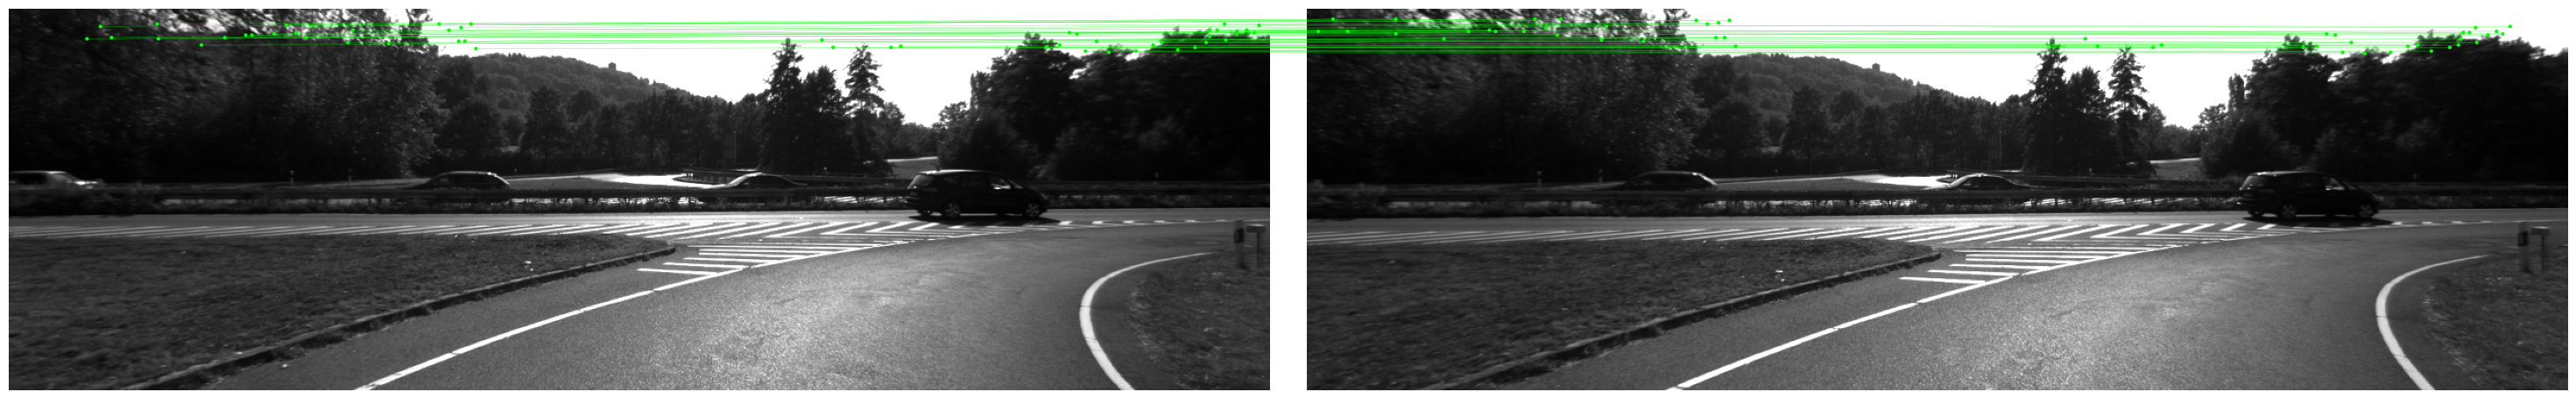

In [85]:
print(len(scores))
print(len(q1))
print(len(q2))
print(q1[:10])
for j in range (50):
    
    print(f"Keypoint {j+1}: {q1[j]}, {q2[j]}, score: {scores[j]}")
imA = cv2.imread(os.path.join(images, imgs[5]), cv2.IMREAD_GRAYSCALE)
imB = cv2.imread(os.path.join(images, imgs[6]), cv2.IMREAD_GRAYSCALE)
viz2d.plot_images([imA, imB])
viz2d.plot_matches(q1[:50], q2[:50], color="lime", lw=0.2)

In [ ]:
for j in range(10):
    
    image0_cv2 = cv2.imread(os.path.join(images, imgs[j]), cv2.IMREAD_GRAYSCALE)
    image1_cv2 = cv2.imread(os.path.join(images, imgs[j+1]), cv2.IMREAD_GRAYSCALE)
    matches_cv2 = [cv2.DMatch(i, i, 0) for i in range(len(matches))]
    keypoints1 = [cv2.KeyPoint(x=q1[i, 0], y=q1[i, 1], size=10) for i in range(len(q1))]
    keypoints2 = [cv2.KeyPoint(x=q2[i, 0], y=q2[i, 1], size=10) for i in range(len(q2))]    
    res =cv2.drawMatches( image0_cv2, keypoints1, image1_cv2, keypoints2, matches_cv2, None, matchColor= (0,255,0), singlePointColor= None, matchesMask=None, flags=2, matchesThickness=2)
    plt.imshow(res)
    plt.show()

**VO with ORB and Knn**

In [7]:
from scipy.optimize import least_squares

class VisualOdometry():
    def __init__(self, data_dir):
        self.K, self.P = self._load_calib("calib.txt")
        self.gt_poses = self._load_poses("poses.txt")
        self.images = self._load_images(images)
        self.orb = cv2.ORB_create(3000)
        FLANN_INDEX_LSH = 6
        index_params = dict(algorithm=FLANN_INDEX_LSH, table_number=6, key_size=12, multi_probe_level=1)
        search_params = dict(checks=50)
        self.flann = cv2.FlannBasedMatcher(indexParams=index_params, searchParams=search_params)

    @staticmethod
    def _load_calib(filepath):
        """
        Loads the calibration of the camera
        Parameters
        ----------
        filepath (str): The file path to the camera file

        Returns
        -------
        K (ndarray): Intrinsic parameters
        P (ndarray): Projection matrix
        """
        with open(filepath, 'r') as f:
            params = np.fromstring(f.readline(), dtype=np.float64, sep=' ')
            P = np.reshape(params, (3, 4))
            K = P[0:3, 0:3]
        return K, P

    @staticmethod
    def _load_poses(filepath):
        """
        Loads the GT poses

        Parameters
        ----------
        filepath (str): The file path to the poses file

        Returns
        -------
        poses (ndarray): The GT poses
        """
        poses = []
        with open(filepath, 'r') as f:
            for line in f.readlines():
                T = np.fromstring(line, dtype=np.float64, sep=' ')
                T = T.reshape(3, 4)
                T = np.vstack((T, [0, 0, 0, 1]))
                poses.append(T)
        return poses

    @staticmethod
    def _load_images(filepath):
        """
        Loads the images

        Parameters
        ----------
        filepath (str): The file path to image dir

        Returns
        -------
        images (list): grayscale images
        """
        image_paths = [os.path.join(filepath, file) for file in sorted(os.listdir(filepath))]
        return [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in image_paths]

    @staticmethod
    def _form_transf(R, t):
        """
        Makes a transformation matrix from the given rotation matrix and translation vector

        Parameters
        ----------
        R (ndarray): The rotation matrix
        t (list): The translation vector

        Returns
        -------
        T (ndarray): The transformation matrix
        """
        T = np.eye(4, dtype=np.float64)
        T[:3, :3] = R
        T[:3, 3] = t
        return T

    def get_matches(self, i):
        """
        This function detect and compute keypoints and descriptors from the i-1'th and i'th image using the class orb object

        Parameters
        ----------
        i (int): The current frame

        Returns
        -------
        q1 (ndarray): The good keypoints matches position in i-1'th image
        q2 (ndarray): The good keypoints matches position in i'th image
        """
        # Find the keypoints and descriptors with ORB
        kp1, des1 = self.orb.detectAndCompute(self.images[i - 1], None)
        kp2, des2 = self.orb.detectAndCompute(self.images[i], None)
        # Find matches
        matches = self.flann.knnMatch(des1, des2, k=2)

        # Find the matches there do not have a to high distance
        good = []
        try:
            for m, n in matches:
                if m.distance < 0.8 * n.distance:
                    good.append(m)
        except ValueError:
            pass

        draw_params = dict(matchColor = 2, # draw matches in green color -1
                 singlePointColor = None,
                 matchesMask = None, # draw only inliers
                 flags = 2)

        #img3 = cv2.drawMatches(self.images[i], kp1, self.images[i-1],kp2, good ,None,**draw_params)
        #plt.imshow(img3)
        #plt.show()
        #cv2.imshow("image", img3)
        #cv2.waitKey(200)

        # Get the image points form the good matches
        q1 = np.float32([kp1[m.queryIdx].pt for m in good])
        q2 = np.float32([kp2[m.trainIdx].pt for m in good])
        return q1, q2

    def get_pose(self, q1, q2):
        """
        Calculates the transformation matrix

        Parameters
        ----------
        q1 (ndarray): The good keypoints matches position in i-1'th image
        q2 (ndarray): The good keypoints matches position in i'th image

        Returns
        -------
        transformation_matrix (ndarray): The transformation matrix
        """
        # Essential matrix
        E, _ = cv2.findEssentialMat(q1, q2, self.K, threshold=1)

        # Decompose the Essential matrix into R and t
        R, t = self.decomp_essential_mat(E, q1, q2)

        # Get transformation matrix
        transformation_matrix = self._form_transf(R, np.squeeze(t))
        return transformation_matrix

    def decomp_essential_mat(self, E, q1, q2):
        """
        Decompose the Essential matrix

        Parameters
        ----------
        E (ndarray): Essential matrix
        q1 (ndarray): The good keypoints matches position in i-1'th image
        q2 (ndarray): The good keypoints matches position in i'th image

        Returns
        -------
        right_pair (list): Contains the rotation matrix and translation vector
        """
        def sum_z_cal_relative_scale(R, t):
            # Get the transformation matrix
            T = self._form_transf(R, t)
            # Make the projection matrix
            P = np.matmul(np.concatenate((self.K, np.zeros((3, 1))), axis=1), T)

            # Triangulate the 3D points
            hom_Q1 = cv2.triangulatePoints(self.P, P, q1.T, q2.T)
            # Also seen from cam 2
            hom_Q2 = np.matmul(T, hom_Q1)

            # Un-homogenize
            uhom_Q1 = hom_Q1[:3, :] / hom_Q1[3, :]
            uhom_Q2 = hom_Q2[:3, :] / hom_Q2[3, :]

            # Find the number of points there has positive z coordinate in both cameras
            sum_of_pos_z_Q1 = sum(uhom_Q1[2, :] > 0)
            sum_of_pos_z_Q2 = sum(uhom_Q2[2, :] > 0)

            # Form point pairs and calculate the relative scale
            relative_scale = np.mean(np.linalg.norm(uhom_Q1.T[:-1] - uhom_Q1.T[1:], axis=-1)/
                                     np.linalg.norm(uhom_Q2.T[:-1] - uhom_Q2.T[1:], axis=-1))
            return sum_of_pos_z_Q1 + sum_of_pos_z_Q2, relative_scale

        # Decompose the essential matrix
        R1, R2, t = cv2.decomposeEssentialMat(E)
        t = np.squeeze(t)

        # Make a list of the different possible pairs
        pairs = [[R1, t], [R1, -t], [R2, t], [R2, -t]]

        # Check which solution there is the right one
        z_sums = []
        relative_scales = []
        for R, t in pairs:
            z_sum, scale = sum_z_cal_relative_scale(R, t)
            z_sums.append(z_sum)
            relative_scales.append(scale)

        # Select the pair there has the most points with positive z coordinate
        right_pair_idx = np.argmax(z_sums)
        right_pair = pairs[right_pair_idx]
        relative_scale = relative_scales[right_pair_idx]
        R1, t = right_pair
        t = t * relative_scale

        return [R1, t]
    #######################################
    def optimize_IRLS(self, q1, q2, transf):
        R = transf[:3, :3]
        t = transf[:3, 3]
        
        P = np.matmul(np.concatenate((self.K, np.zeros((3,1))), axis=1), transf)
        
        h_Q1 = cv2.triangulatePoints(self.P, P, q1.T, q2.T)
        h_Q2 = np.matmul(transf, h_Q1)
        
        Q1 = h_Q1[:3, :] / h_Q1[3, :]
        Q2 = h_Q2[:3, :] / h_Q2[3, :]
        
        Q1 = Q1.T
        Q2 = Q2.T
        
        def residuals(p, q1, q2, Q1, Q2):
            """
            transf = p.reshape((4,4))
            R = transf[:3, :3]
            t = transf[:3, 3]
            rvec, _ = cv2.Rodrigues(R)
            proj_q2_cv2, _ = cv2.projectPoints(p3d, rvec, t, self.K, None)
            proj_q2 = np.squeeze(proj_q2_cv2)
            #print(f"Projection : {proj_q2.shape}")
            #print(f"Real points : {q2.shape}")
            reprojection_error = np.abs(proj_q2.flatten() - q2.flatten())
            """
            #print(f"q1 {q1.shape}")
            #print(f"q2 {q2.shape}")
            #print(f"Q1 {Q1.shape}")
            #print(f"Q2 {Q2.shape}")
            r = p[:3]
            R, _ = cv2.Rodrigues(r)
            t = p[3:]
            transf = self._form_transf(R,t)
            
            f_projection = np.matmul(self.P, transf)
            b_projection = np.matmul(self.P, np.linalg.inv(transf))
            
            ones = np.ones((q1.shape[0], 1))
            Q1 = np.hstack([Q1, ones])
            Q2 = np.hstack([Q2, ones])
            
            # Project 3D points from i'th image to i-1'th image
            q1_pred = Q2.dot(f_projection.T)
            # Un-homogenize
            q1_pred = q1_pred[:, :2].T / q1_pred[:, 2]
            # Project 3D points from i-1'th image to i'th image
            q2_pred = Q1.dot(b_projection.T)
            # Un-homogenize
            q2_pred = q2_pred[:, :2].T / q2_pred[:, 2]
            residuals = np.vstack([q1_pred - q1.T, q2_pred - q2.T]).flatten()
            return residuals
        
        early_term_th = 5
        max_iter = 100
        min_error = float('inf')
        early_term = 0
        
        for n in range(max_iter):
            # Choose 6 random feature points
            sample_idx = np.random.choice(range(q1.shape[0]), 6)
            sample_q1, sample_q2, sample_Q1, sample_Q2 = q1[sample_idx], q2[sample_idx], Q1[sample_idx], Q2[sample_idx]
            
            if n == 0:
                initial_guess = np.array([0, 0, 0, 0, 0, -1])#transf[:3, :].flatten()
                better_sol = False
            else:
                if better_sol == True:
                    initial_guess = out_pose
                    better_sol = False
                else:
                    initial_guess = result.x
            #print(f"InG: {initial_guess.shape}")
            result = least_squares(residuals, initial_guess, args=(sample_q1, sample_q2, sample_Q1, sample_Q2), method='lm', max_nfev=200)
            # Calculate the error for the optimized transformation
            error = residuals(result.x, q1, q2, Q1, Q2)
            error = error.reshape((Q1.shape[0] * 2, 2))
            error = np.sum(np.linalg.norm(error, axis=1))
            
            #IRLS optimization
            for j in range(5):
                # Compute weights
                weights = 1/ np.sqrt(np.abs(error) + 1e-9)
                weights /= np.sum(weights)
                weighted_residuals = weights * residuals(result.x, q1, q2, Q1, Q2)
                
                result = least_squares(residuals, initial_guess, method='lm', max_nfev=200, ftol=1e-4, xtol=1e-4, f_scale=weighted_residuals,
                                       args=(sample_q1, sample_q2, sample_Q1, sample_Q2))
            
            # Check if the error is less the the current min error. Save the result if it is
            if error < min_error:
                min_error = error
                out_pose = result.x
                early_term = 0
                better_sol = True
            else:
                early_term += 1
            if early_term == early_term_th:
                # If we have not fund any better result in early_termi_th iterations
                break
            
        r_o = out_pose[:3]
        R_o, _ = cv2.Rodrigues(r_o)
        t_o = out_pose[3:]
        optimized_transf = self._form_transf(R_o, t_o)
        #print(f"OT:\n {optimized_transf}")
        
        return optimized_transf



vo = VisualOdometry(images)

#play_trip(vo.images)  # Comment out to not play the trip

gt_path = []
estimated_path = []
for i in range(100):
    gt_pose = vo.gt_poses[i]
    if i == 0:
        cur_pose = gt_pose
    else:
        q1, q2 = vo.get_matches(i)
        transf = vo.get_pose(q1, q2)
        optim_transf = vo.optimize_IRLS(q1, q2, transf)
        cur_pose = np.matmul(cur_pose, optim_transf)
    gt_path.append((gt_pose[0, 3], gt_pose[2, 3]))
    estimated_path.append((cur_pose[0, 3], cur_pose[2, 3]))
visualize_paths(gt_path, estimated_path, "Visual Odometry", title="VO ORB + KNN", file_out=os.path.basename(".") + ".html")



**VO with SuperPoint and LightGlue**

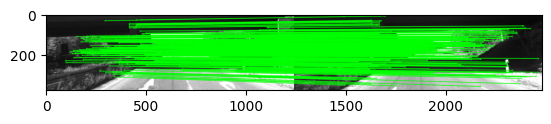

In [5]:
class VisualOdometryLightGlue():
    def __init__(self, data_dir):
        self.K, self.P = self._load_calib("calib.txt")
        self.gt_poses = self._load_poses("poses.txt")
        self.images = self._load_images(images)
        self.extractor = SuperPoint(num_max_keypoints=2048).eval().to(device)
        self.matcher = LightGlue("superpoint").eval().to(device)
        #self.orb = cv2.ORB_create(3000)
        #FLANN_INDEX_LSH = 6
        #index_params = dict(algorithm=FLANN_INDEX_LSH, table_number=6, key_size=12, multi_probe_level=1)
        #search_params = dict(checks=50)
        #self.flann = cv2.FlannBasedMatcher(indexParams=index_params, searchParams=search_params)

    @staticmethod
    def _load_calib(filepath):
        """
        Loads the calibration of the camera
        Parameters
        ----------
        filepath (str): The file path to the camera file

        Returns
        -------
        K (ndarray): Intrinsic parameters
        P (ndarray): Projection matrix
        """
        with open(filepath, 'r') as f:
            params = np.fromstring(f.readline(), dtype=np.float64, sep=' ')
            P = np.reshape(params, (3, 4))
            K = P[0:3, 0:3]
        return K, P

    @staticmethod
    def _load_poses(filepath):
        """
        Loads the GT poses

        Parameters
        ----------
        filepath (str): The file path to the poses file

        Returns
        -------
        poses (ndarray): The GT poses
        """
        poses = []
        with open(filepath, 'r') as f:
            for line in f.readlines():
                T = np.fromstring(line, dtype=np.float64, sep=' ')
                T = T.reshape(3, 4)
                T = np.vstack((T, [0, 0, 0, 1]))
                poses.append(T)
        return poses

    @staticmethod
    def _load_images(filepath):
        """
        Loads the images

        Parameters
        ----------
        filepath (str): The file path to image dir

        Returns
        -------
        images (list): grayscale images
        """
        image_paths = [os.path.join(filepath, file) for file in sorted(os.listdir(filepath))]
        return [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in image_paths]

    @staticmethod
    def _form_transf(R, t):
        """
        Makes a transformation matrix from the given rotation matrix and translation vector

        Parameters
        ----------
        R (ndarray): The rotation matrix
        t (list): The translation vector

        Returns
        -------
        T (ndarray): The transformation matrix
        """
        T = np.eye(4, dtype=np.float64)
        T[:3, :3] = R
        T[:3, 3] = t
        return T

    def get_matches(self, i):
        """
        This function detect and compute keypoints and descriptors from the i-1'th and i'th image using the class orb object

        Parameters
        ----------
        i (int): The current frame

        Returns
        -------
        q1 (ndarray): The good keypoints matches position in i-1'th image
        q2 (ndarray): The good keypoints matches position in i'th image
        """
        clear_output(wait=True)
        # Find the keypoints and descriptors with SuperPoint
        feats0 = self.extractor.extract(numpy_image_to_torch(self.images[i-1]).to(device))
        feats1 = self.extractor.extract(numpy_image_to_torch(self.images[i]).to(device))      
        
        # Find matches
        matches01 = self.matcher({"image0": feats0, "image1": feats1})
        # Remove batch dimension
        feats0, feats1, matches01 = [rbd(x) for x in [feats0, feats1, matches01]]
        
        kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
        
        
        

        scores = matches01["scores"].detach().numpy()
        #print(len(scores))
        
        good = []
        for j in range(len(scores)):
            if scores[j] > 0.9:
                good.append(matches[j])
        
        
        #print(good)
        #test0, test1 = kpts0[matches[...,0]], kpts1[matches[...,1]]
        m_kpts0 = kpts0[[good[x][0] for x in range(len(good))]].detach().numpy()
        m_kpts1 = kpts1[[good[x][1] for x in range(len(good))]].detach().numpy()

        
        matches_cv2 = [cv2.DMatch(j, j, 0) for j in range(len(good))]
        keypoints1 = [cv2.KeyPoint(x=m_kpts0[j, 0], y=m_kpts0[j, 1], size=10) for j in range(len(m_kpts0))]
        keypoints2 = [cv2.KeyPoint(x=m_kpts1[j, 0], y=m_kpts1[j, 1], size=10) for j in range(len(m_kpts1))] 
        res =cv2.drawMatches( self.images[i-1], keypoints1, self.images[i], keypoints2, matches_cv2, None, matchColor= (0,255,0), singlePointColor= None, matchesMask=None, flags=2, matchesThickness=2)
        plt.imshow(res)
        plt.pause(0.1)
        plt.show()
        #cv2.imshow("image", img3)
        #cv2.waitKey(200)

        # Get the image points form the good matches
        q1 = np.float32(m_kpts0)
        q2 = np.float32(m_kpts1)
        return q1, q2

    def get_pose(self, q1, q2):
        """
        Calculates the transformation matrix

        Parameters
        ----------
        q1 (ndarray): The good keypoints matches position in i-1'th image
        q2 (ndarray): The good keypoints matches position in i'th image

        Returns
        -------
        transformation_matrix (ndarray): The transformation matrix
        """
        # Essential matrix
        E, _ = cv2.findEssentialMat(q1, q2, self.K, threshold=1)

        # Decompose the Essential matrix into R and t
        R, t = self.decomp_essential_mat(E, q1, q2)

        # Get transformation matrix
        transformation_matrix = self._form_transf(R, np.squeeze(t))
        return transformation_matrix

    def decomp_essential_mat(self, E, q1, q2):
        """
        Decompose the Essential matrix

        Parameters
        ----------
        E (ndarray): Essential matrix
        q1 (ndarray): The good keypoints matches position in i-1'th image
        q2 (ndarray): The good keypoints matches position in i'th image

        Returns
        -------
        right_pair (list): Contains the rotation matrix and translation vector
        """
        def sum_z_cal_relative_scale(R, t):
            # Get the transformation matrix
            T = self._form_transf(R, t)
            # Make the projection matrix
            P = np.matmul(np.concatenate((self.K, np.zeros((3, 1))), axis=1), T)

            # Triangulate the 3D points
            hom_Q1 = cv2.triangulatePoints(self.P, P, q1.T, q2.T)
            # Also seen from cam 2
            hom_Q2 = np.matmul(T, hom_Q1)

            # Un-homogenize
            uhom_Q1 = hom_Q1[:3, :] / hom_Q1[3, :]
            uhom_Q2 = hom_Q2[:3, :] / hom_Q2[3, :]

            # Find the number of points there has positive z coordinate in both cameras
            sum_of_pos_z_Q1 = sum(uhom_Q1[2, :] > 0)
            sum_of_pos_z_Q2 = sum(uhom_Q2[2, :] > 0)

            # Form point pairs and calculate the relative scale
            relative_scale = np.mean(np.linalg.norm(uhom_Q1.T[:-1] - uhom_Q1.T[1:], axis=-1)/
                                     np.linalg.norm(uhom_Q2.T[:-1] - uhom_Q2.T[1:], axis=-1))
            return sum_of_pos_z_Q1 + sum_of_pos_z_Q2, relative_scale

        # Decompose the essential matrix
        R1, R2, t = cv2.decomposeEssentialMat(E)
        t = np.squeeze(t)

        # Make a list of the different possible pairs
        pairs = [[R1, t], [R1, -t], [R2, t], [R2, -t]]

        # Check which solution there is the right one
        z_sums = []
        relative_scales = []
        for R, t in pairs:
            z_sum, scale = sum_z_cal_relative_scale(R, t)
            z_sums.append(z_sum)
            relative_scales.append(scale)

        # Select the pair there has the most points with positive z coordinate
        right_pair_idx = np.argmax(z_sums)
        right_pair = pairs[right_pair_idx]
        relative_scale = relative_scales[right_pair_idx]
        R1, t = right_pair
        t = t * relative_scale

        return [R1, t]


images = Path("../Lane_detection/kitti01_image0/")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vo = VisualOdometryLightGlue(images)

#play_trip(vo.images)  # Comment out to not play the trip

gt_path = []
estimated_path = []
for i in range(100):
    gt_pose = vo.gt_poses[i]
    if i == 0:
        cur_pose = gt_pose
    else:
        q1, q2 = vo.get_matches(i)
        transf = vo.get_pose(q1, q2)
        cur_pose = np.matmul(cur_pose, np.linalg.inv(transf))
    gt_path.append((gt_pose[0, 3], gt_pose[2, 3]))
    estimated_path.append((cur_pose[0, 3], cur_pose[2, 3]))
visualize_paths(gt_path, estimated_path, "Visual Odometry", title="VO SuperPoint + LightGlue", file_out=os.path.basename(".") + ".html")

